In [132]:
import lda
import gensim
import gensim.corpora as corpora
import pyLDAvis.sklearn
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [63]:
df = pd.read_csv('Billboard_lyrics_2720.csv')
df = df.dropna()
df.head()

,Unnamed: 0,title,artist,Spotify_ID,Spotify_Popularity,Is_Explicit,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,lyrics
0,0,Sicko Mode,Travis Scott,2xLMifQCjDGFmkHkpNLD9h,96.0,True,0.00513,0.834,0.730,0.0,0.1240,-3.714,1.0,0.2220,155.008,0.446,"\n\n[Part I]\n\n[Intro: Drake]\nAstro, yeah\nS..."
1,2,Lucid Dreams,Juice WRLD,0s3nnoMeVWz3989MkNQiRf,95.0,True,0.34900,0.511,0.566,0.0,0.3400,-7.230,0.0,0.2000,83.903,0.218,"\n\n[Intro]\nEnviyon on the mix\nNo, no, no, n..."
2,4,Better Now,Post Malone,7dt6x5M1jzdTEt8oCbisTK,94.0,True,0.35400,0.680,0.563,0.0,0.1360,-5.843,1.0,0.0454,145.028,0.374,\n\n[Chorus]\nYou prolly think that you are be...
3,5,ZEZE,Kodak Black Featuring Travis Scott & Offset,7l3E7lcozEodtVsSTCkcaA,95.0,True,0.07100,0.826,0.615,0.0,0.0965,-7.979,0.0,0.2190,98.056,0.543,\n\n[Intro]\nD.A. got that dope!\n\n[Chorus: T...
4,6,Drip Too Hard,Lil Baby & Gunna,1BxkZE73h9BN3qwuA15TA3,90.0,True,0.09450,0.900,0.653,0.0,0.5280,-6.962,0.0,0.2890,112.503,0.399,"\n\n[Intro]\nRun that back, Turbo\n\n[Verse 1:..."


In [64]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ziyulei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
df['lyrics'][0]

'\n\n[Part I]\n\n[Intro: Drake]\nAstro, yeah\nSun is down, freezin\' cold\nThat\'s how we already know, winter\'s here\nMy dawg would probably do it for a Louis belt\nThat\'s just all he know, he don\'t know nothin\' else\nI tried to show \'em, yeah\nI tried to show \'em, yeah, yeah\nYeah, yeah, yeah\nGoin\' on you with the pick and roll\nYoung La Flame, he in sicko mode\n\n[Part II]\n\n[Verse 1: Travis Scott & The Notorious B.I.G.]\nWoo, made this here with all the ice on in the booth\nAt the gate outside, when they pull up, they get me loose\nYeah, Jump Out boys, that\'s Nike boys, hoppin\' out coupes\nThis shit way too big when we pull up give me the loot\n(Gimme the loot!)\nWas off the Remy, had a Papoose\nHad to hit my old town to duck the news\nTwo four hour lockdown, we made no moves\nNow it\'s 4 AM and I\'m back up poppin\' with the crew\nI just landed in, Chase B mix this pop like Jamba Juice\nDifferent colored chains, think my jeweler really sellin\' fruits\nAnd they chokin\'

In [66]:
stoplist= set(stopwords.words('english'))
stemmer = PorterStemmer()

In [67]:
def preprocess(text,stops=False,stemming=False,min_word_len=0):
    if type(text) == float:
        pass
    else:
        clean = ''.join([ch if ord(ch) < 128 else ' ' for ch in text])
        #t = str.maketrans("","")
        clean = clean.lower().translate(str.maketrans('','',punctuation))
        clean = ''.join([ch for ch in clean if not ch.isdigit()])
        clean = ' '.join([w for w in clean.split() if len(w) >= min_word_len])
        if stops & stemming:
            return ' '.join([stemmer.stem(w) for w in clean.split() if (w not in stoplist) & (len(w) >= min_word_len)])
        elif stops:
            return ' '.join([w for w in clean.split() if (w not in stoplist) & (len(w) >= min_word_len)])
        elif stemming:
            return ' '.join([stemmer.stem(w) for w in clean.split() if (len(w) >= min_word_len)])
        return ' '.join([w for w in clean.split() if (len(w) >= min_word_len)])

df['Processed'] = df['lyrics'].apply(lambda x: preprocess(x,stops=True,stemming=True,min_word_len=3))

In [69]:
df.head()

,Unnamed: 0,title,artist,Spotify_ID,Spotify_Popularity,Is_Explicit,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,lyrics,Processed
0,0,Sicko Mode,Travis Scott,2xLMifQCjDGFmkHkpNLD9h,96.0,True,0.00513,0.834,0.730,0.0,0.1240,-3.714,1.0,0.2220,155.008,0.446,"\n\n[Part I]\n\n[Intro: Drake]\nAstro, yeah\nS...",part intro drake astro yeah sun freezin cold t...
1,2,Lucid Dreams,Juice WRLD,0s3nnoMeVWz3989MkNQiRf,95.0,True,0.34900,0.511,0.566,0.0,0.3400,-7.230,0.0,0.2000,83.903,0.218,"\n\n[Intro]\nEnviyon on the mix\nNo, no, no, n...",intro enviyon mix nono choru still see shadow ...
2,4,Better Now,Post Malone,7dt6x5M1jzdTEt8oCbisTK,94.0,True,0.35400,0.680,0.563,0.0,0.1360,-5.843,1.0,0.0454,145.028,0.374,\n\n[Chorus]\nYou prolly think that you are be...,choru prolli think better better say caus arou...
3,5,ZEZE,Kodak Black Featuring Travis Scott & Offset,7l3E7lcozEodtVsSTCkcaA,95.0,True,0.07100,0.826,0.615,0.0,0.0965,-7.979,0.0,0.2190,98.056,0.543,\n\n[Intro]\nD.A. got that dope!\n\n[Chorus: T...,intro got dope choru travi scott ice water tur...
4,6,Drip Too Hard,Lil Baby & Gunna,1BxkZE73h9BN3qwuA15TA3,90.0,True,0.09450,0.900,0.653,0.0,0.5280,-6.962,0.0,0.2890,112.503,0.399,"\n\n[Intro]\nRun that back, Turbo\n\n[Verse 1:...",intro run back turbo vers lil babi get biggest...


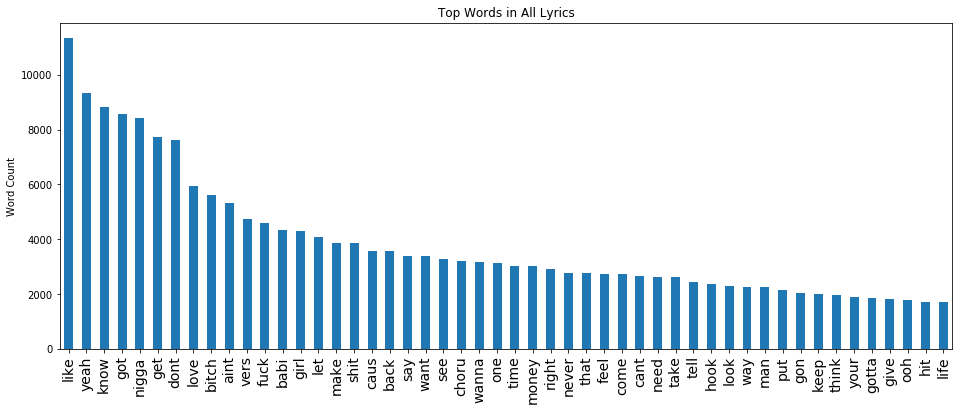

In [71]:
all_lyrics = ' '.join(df['Processed'])
vectorizer = CountVectorizer()
counts = vectorizer.fit_transform([all_lyrics])

top_words = pd.DataFrame(counts.todense(),columns=vectorizer.get_feature_names()).transpose().sort_values(0,ascending=False)
labels = list(top_words[:50].index)


top_words[:50].plot(kind='bar',figsize=(16,6),legend=None)

# labels[4] = '*****'                    # some censorship was necessary
# labels[-8] = '****'
# labels[-15] = '****'

plt.xlabel('')
plt.xticks(range(len(labels)),labels,fontsize=14)

plt.ylabel('Word Count')
plt.title('Top Words in All Lyrics')
plt.show()

In [75]:
def get_artist_lyrics(df):
    artists,lyrics = [],[]
    for artist in df['artist'].unique():
        artists.append(artist)
        all_words = ' '.join(df[df['artist'] == artist]['Processed'])
        lyrics.append(all_words)
        print ('Word Count for %s: %i'  %(artist,len(all_words.split())))
    print ('\nTotal Word Count: %i' %len(' '.join(df['Processed']).split()))
    return artists,lyrics

artists,lyrics = get_artist_lyrics(df)

Word Count for Travis Scott: 5944
Word Count for Juice WRLD: 1010
Word Count for Post Malone: 3570
Word Count for Kodak Black Featuring Travis Scott & Offset: 435
Word Count for Lil Baby & Gunna: 633
Word Count for Sheck Wes: 208
Word Count for Ella Mai: 504
Word Count for Cardi B, Bad Bunny & J Balvin: 488
Word Count for Tyga Featuring Offset: 415
Word Count for Drake: 22493
Word Count for 6ix9ine Featuring Nicki Minaj & Murda Beatz: 318
Word Count for XXXTENTACION x Lil Pump Featuring Maluma & Swae Lee: 96
Word Count for Lil Baby & Drake: 242
Word Count for YG Featuring 2 Chainz, Big Sean & Nicki Minaj: 473
Word Count for Lil Wayne: 6065
Word Count for Cardi B Featuring Kehlani: 249
Word Count for Kanye West & Lil Pump: 239
Word Count for Future & Juice WRLD: 550
Word Count for Lil Baby: 1325
Word Count for NF: 876
Word Count for TakeOff: 317
Word Count for Flipp Dinero: 265
Word Count for Khalid: 888
Word Count for Yella Beezy: 438
Word Count for Meek Mill Featuring Jeremih & PnB Ro

Word Count for Eminem Featuring PHRESHER: 658
Word Count for Calvin Harris Featuring Kehlani & Lil Yachty: 274
Word Count for Migos & Marshmello: 347
Word Count for Huncho Jack Featuring Takeoff: 367
Word Count for 21 Savage: 1439
Word Count for Huncho Jack: 884
Word Count for Huncho Jack Featuring Offset: 323
Word Count for Tay-K: 215
Word Count for Eminem Featuring Beyonce: 636
Word Count for Logic Featuring Alessia Cara & Khalid: 282
Word Count for Yo Gotti Featuring Nicki Minaj: 286
Word Count for Big Sean & Metro Boomin Featuring Travis Scott: 387
Word Count for Big Sean & Metro Boomin Featuring 21 Savage: 441
Word Count for Wiz Khalifa Featuring Ty Dolla $ign: 284
Word Count for GoldLink Featuring Brent Faiyaz & Shy Glizzy: 350
Word Count for Miguel Featuring J. Cole & Salaam Remi: 189
Word Count for Jaden Smith: 292
Word Count for DJ Khaled Featuring Rihanna & Bryson Tiller: 260
Word Count for Jacquees: 320
Word Count for 21 Savage, Offset & Metro Boomin Featuring Quavo: 463
Wor

Word Count for Drake Featuring Pimp C & dvsn: 442
Word Count for Chance The Rapper Featuring Ty Dolla $ign: 385
Word Count for Kid Ink Featuring Fetty Wap: 274
Word Count for Chance The Rapper Featuring Kanye West & Chicago Children's Choir: 236
Word Count for Chance The Rapper Featuring Justin Bieber & Towkio: 4894
Word Count for Chance The Rapper Featuring Young Thug & Lil Yachty: 411
Word Count for Beyonce Featuring The Weeknd: 290
Word Count for Ty Dolla $ign Featuring E-40: 326
Word Count for Prince And The Revolution: 799
Word Count for Prince: 787
Word Count for Snakehips Featuring Tinashe & Chance The Rapper: 232
Word Count for Plies: 1304
Word Count for G-Eazy Featuring Starrah: 380
Word Count for Drake & Future: 2669
Word Count for Maxwell: 709
Word Count for Alessia Cara: 204
Word Count for 2 Chainz: 1145
Word Count for Zendaya Featuring Chris Brown: 267
Word Count for Wiz Khalifa Featuring Travi$ Scott: 347
Word Count for DLOW: 288
Word Count for Hopsin: 597
Word Count for 

Word Count for We Are Toonz: 130
Word Count for Iggy Azalea Featuring T.I.: 368
Word Count for G-Eazy Featuring A$AP Ferg & Danny Seth: 91
Word Count for Bando Jonez: 167
Word Count for Aloe Blacc: 273
Word Count for Mike WiLL Made-It Featuring Future, Lil Wayne & Kendrick Lamar: 86
Word Count for Rick Ross Featuring Lil Wayne: 359
Word Count for Ludacris Featuring Wiz Khalifa , Jeremih & Cashmere Cat: 357
Word Count for Eminem Featuring Nate Ruess: 439
Word Count for Tech N9ne Featuring Kendrick Lamar, MAYDAY! & Kendall Morgan: 285
Word Count for Mariah Carey: 975
Word Count for Yo Gotti Featuring Rich Homie Quan: 375
Word Count for Ty Dolla $ign Featuring B.o.B: 312
Word Count for Young Money Featuring Tyga, Nicki Minaj & Lil Wayne: 358
Word Count for B.o.B Featuring Priscilla: 290
Word Count for Alicia Keys Featuring Kendrick Lamar: 260
Word Count for DJ Khaled Featuring T-Pain, Ludacris, Snoop Dogg & Rick Ross: 769
Word Count for G-Eazy Featuring Devon Baldwin: 266
Word Count for J

Word Count for 50 Cent Featuring Dr. Dre & Alicia Keys: 146
Word Count for Curren$Y Featuring Big K.R.I.T. & Wiz Khalifa: 196
Word Count for Daley Featuring Marsha Ambrosius: 146
Word Count for Faith Evans: 285
Word Count for Antoine Dunn: 124
Word Count for Pleasure P Featuring Tyga: 330
Word Count for Whitney Houston & R. Kelly: 98
Word Count for Jacob Latimore: 190
Word Count for Nicki Minaj Featuring Cam'ron & Rick Ross: 87
Word Count for Tank Featuring T.I. & Kris Stephens: 275
Word Count for Melanie Fiona: 907
Word Count for Drake Featuring The Weeknd: 200
Word Count for Rick Ross Featuring Usher: 25
Word Count for Chachillie: 393
Word Count for DJ Scream Featuring 2 Chainz, Future, Waka Flocka Flame, Yo Gotti & Gucci Mane: 230
Word Count for King L: 306
Word Count for Birdman Featuring Rick Ross: 408
Word Count for Sterling Simms Featuring Meek Mill: 250
Word Count for Nicki Minaj Featuring 2 Chainz: 420
Word Count for Rick Ross Featuring Meek Mill: 399
Word Count for Leah LaBel

Word Count for Rantz Davis: 227
Word Count for Lupe Fiasco: 625
Word Count for Diddy - Dirty Money Featuring Skylar Grey: 335
Word Count for T.I. Featuring Drake: 396
Word Count for Tank Featuring Drake: 238
Word Count for Jim Jones Featuring Chink Santana & Logic: 228
Word Count for Lil Kee Featuring The Keezone Boyz: 373
Word Count for Charlie Wilson Featuring Fantasia: 126
Word Count for Lloyd: 149
Word Count for Birdman Featuring Lil Wayne: 621
Word Count for Mo-Pain Featuring Yo Gotti & Chubbie: 502
Word Count for Mann: 327
Word Count for Chris Brown Featuring Tyga & Kevin McCall: 332
Word Count for Bow Wow Featuring Chris Brown: 302
Word Count for Ginuwine: 182
Word Count for Rihanna Featuring Nicki Minaj: 301
Word Count for Sean Garrett Featuring J. Cole or Drake: 175
Word Count for Miguel Featuring J. Cole: 0
Word Count for Ne-Yo Featuring Fabolous: 185
Word Count for T.I. Featuring Christina Aguilera: 340
Word Count for Jaheim: 414
Word Count for Lloyd Banks Featuring Kanye We


Total Word Count: 642941


In [76]:
n_grams = (1,1)
vectorizer1 = TfidfVectorizer(ngram_range=n_grams)
tf_idf_matrix = vectorizer1.fit_transform(lyrics)
tf_idf_matrix

<1290x20712 sparse matrix of type '<class 'numpy.float64'>'
	with 246387 stored elements in Compressed Sparse Row format>

In [80]:
tf_idf_df = pd.DataFrame(tf_idf_matrix.todense(),index=artists,columns=vectorizer.get_feature_names())
tf_idf_df.iloc[:,2000:2010].head()

,boob,boobi,booboo,boobooboom,booboobooti,booch,bood,boof,booga,boogaloo
Travis Scott,0.00589,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Juice WRLD,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Post Malone,0.00000,0.0,0.012935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kodak Black Featuring Travis Scott & Offset,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lil Baby & Gunna,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
tf_idf_df.loc['Eminem'].sort_values(ascending=False)[:10]

fack        0.262457
like        0.197259
caus        0.169867
dont        0.148564
gonna       0.140390
phenomen    0.138158
legaci      0.136903
get         0.136522
your        0.129800
back        0.116716
Name: Eminem, dtype: float64

In [83]:

n_grams = (1,1)

vectorizer2 = CountVectorizer(ngram_range=n_grams)
tdm = vectorizer2.fit_transform(lyrics)
tdm

<1290x20712 sparse matrix of type '<class 'numpy.int64'>'
	with 246387 stored elements in Compressed Sparse Row format>

In [134]:
n_topics = 5

model = lda.LDA(n_topics=n_topics, n_iter=1000, random_state=7)
model.fit(tdm)                                                     
topic_words = model.components_
vocab = vectorizer1.get_feature_names()

INFO:lda:n_documents: 1290
INFO:lda:vocab_size: 20712
INFO:lda:n_words: 642941
INFO:lda:n_topics: 5
INFO:lda:n_iter: 1000
/anaconda3/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -5937582
INFO:lda:<10> log likelihood: -5351669
INFO:lda:<20> log likelihood: -5151375
INFO:lda:<30> log likelihood: -5070127
INFO:lda:<40> log likelihood: -5040511
INFO:lda:<50> log likelihood: -5023400
INFO:lda:<60> log likelihood: -5014645
INFO:lda:<70> log likelihood: -5008229
INFO:lda:<80> log likelihood: -5003214
INFO:lda:<90> log likelihood: -4999944
INFO:lda:<100> log likelihood: -4997887
INFO:lda:<110> log likelihood: -4993203
INFO:lda:<120> log likelihood: -4991766
INFO:lda:<130> log likelihood: -4989375
INFO:lda:<140> log likelihood: -4987046

In [135]:
n_words = 10                                                    
for i, topic_dist in enumerate(topic_words):
    top_word_proba = np.sort(topic_dist)[::-1][:n_words]
    top_word_indices = np.argsort(topic_dist)[::-1][:n_words]
    top_words = np.array(vocab)[top_word_indices]
    print ('Topic %i:' %(i))
#     if i == 4:
#         top_words[0] = '*****'                
#         top_words[2] = '****'
#         top_words[4] = '****'
#         top_words[5] = '*****'
    for j in zip(top_words,top_word_proba):
        print ('\t%s:   %f' %(j[0],j[1]))

Topic 0:
	music:   0.025004
	record:   0.016640
	studio:   0.013911
	kany:   0.012414
	west:   0.012062
	produc:   0.009289
	mix:   0.008980
	feat:   0.007704
	inc:   0.007616
	publish:   0.007088
Topic 1:
	yeah:   0.060091
	like:   0.021447
	bitch:   0.016145
	got:   0.015794
	ayi:   0.012334
	dont:   0.012033
	fuck:   0.010479
	choru:   0.010304
	woo:   0.008975
	ooh:   0.008260
Topic 2:
	nigga:   0.044997
	bitch:   0.024339
	got:   0.022578
	like:   0.018506
	fuck:   0.016688
	get:   0.016292
	money:   0.016219
	shit:   0.016208
	aint:   0.013638
	know:   0.008556
Topic 3:
	girl:   0.030307
	babi:   0.030299
	know:   0.026029
	love:   0.025892
	like:   0.022720
	get:   0.019330
	let:   0.016376
	yeah:   0.015610
	make:   0.014940
	dont:   0.014391
Topic 4:
	dont:   0.020249
	know:   0.015497
	like:   0.014669
	love:   0.011243
	yeah:   0.010807
	never:   0.009202
	feel:   0.009056
	time:   0.008948
	cant:   0.008279
	get:   0.007933


In [136]:
doc_topic = model.doc_topic_

results = pd.DataFrame(doc_topic)
results.columns = ['Topic %i' %i for i in results.columns]
results = pd.DataFrame({'Artist':artists}).join(results)
results.head()

,Artist,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,Travis Scott,0.002035,0.412331,0.164370,0.076390,0.344873
1,Juice WRLD,0.000099,0.103018,0.151509,0.069372,0.676002
2,Post Malone,0.000028,0.298586,0.127461,0.059123,0.514802
3,Kodak Black Featuring Travis Scott & Offset,0.000230,0.537543,0.307922,0.000230,0.154076
4,Lil Baby & Gunna,0.003315,0.238516,0.363220,0.004893,0.390055


In [137]:
def viz(results,save=False):
    max_cols = 4
    n_charts = len(results)
    n_cols = max_cols if n_charts >= max_cols else n_charts
    n_rows = ((n_charts / max_cols) + 1) if n_charts % n_cols != 0 else n_charts / n_cols
    
    topics = results.columns.values[1:]
    topic_proba = results.drop('Artist',axis=1).values
    docs = results['Artist'].values
    fig = plt.figure(figsize=(20,18))
    
    for i in range(n_charts):                                          
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        ax = sns.barplot(topics,topic_proba[i],ax=ax)
        plt.xticks(rotation=45)
        ax.set_title(docs[i],fontsize=14)
        sns.set(style="darkgrid")
        plt.ylim([0,1])
    if save:
        plt.savefig('Topic_Model_Lyrics_results.jpg')
    plt.show()

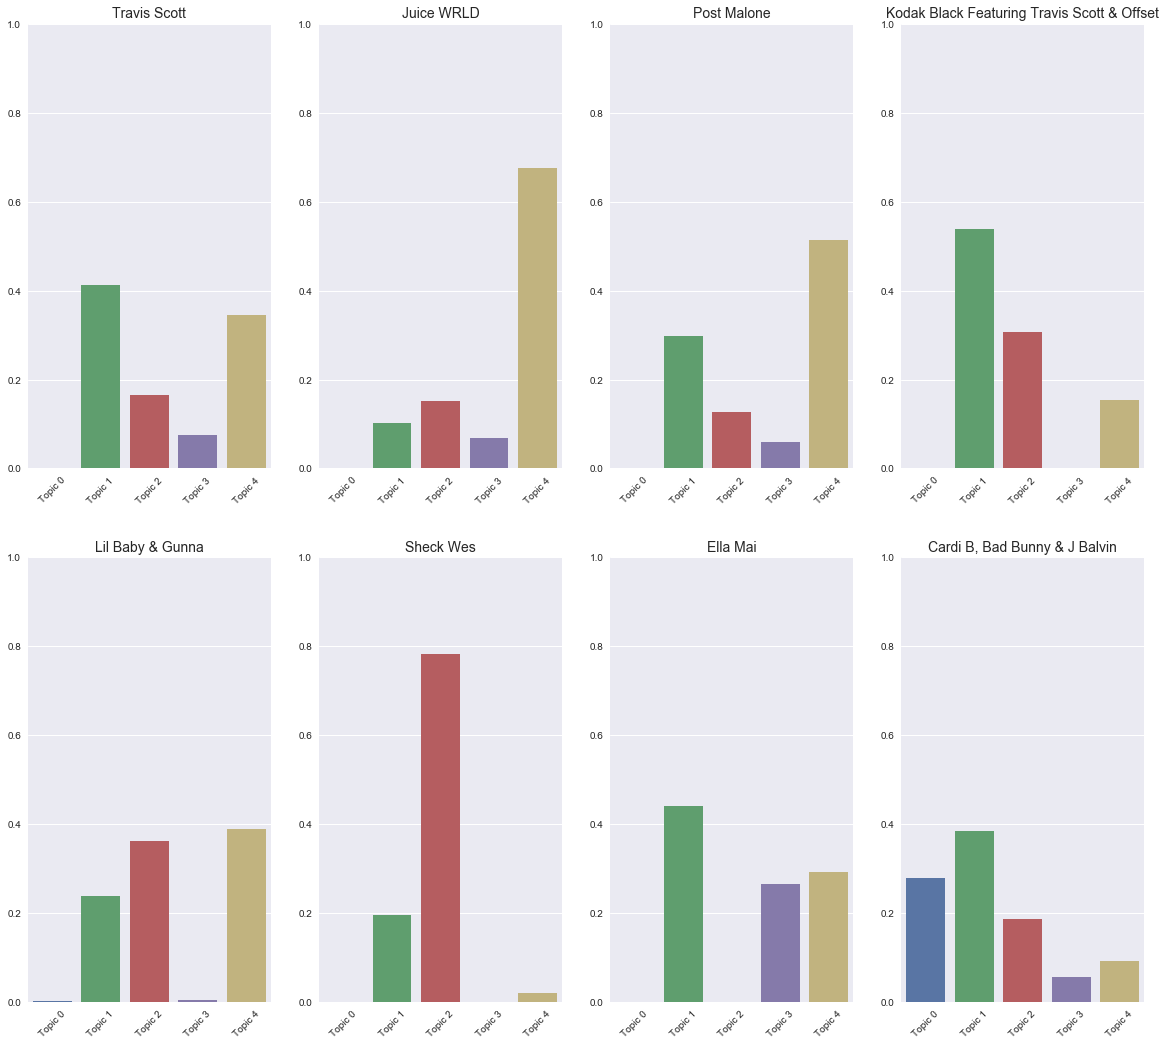

In [138]:
results_8 = results.iloc[:8]
viz(results_8)

In [107]:
# fig = plt.figure(figsize=(16,10))
# sns.heatmap(pd.DataFrame(cosine_similarity(tf_idf_matrix),
#             index=artists,
#             columns=artists),
#             annot=True,
#             annot_kws={'fontsize':16})
# plt.xticks(fontsize=14,rotation=80)
# plt.yticks(fontsize=14)
# plt.show()

In [139]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, tdm, vectorizer2, mds='tsne')
panel

/anaconda3/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      140.448349  -59.836464       1        1  37.077162
2       22.925215 -135.449982       2        1  27.454402
3       88.999016   30.120371       3        1  19.477484
1      126.653450 -162.544174       4        1  12.468447
0        3.107941  -34.038208       5        1   3.522505, topic_info=      Category          Freq       Term         Total  loglift  logprob
term                                                                   
20426  Default   9348.000000       yeah   9348.000000  30.0000  30.0000
12253  Default   8391.000000      nigga   8391.000000  29.0000  29.0000
7220   Default   4348.000000       girl   4348.000000  28.0000  28.0000
1037   Default   4379.000000       babi   4379.000000  27.0000  27.0000
1705   Default   5590.000000      bitch   5590.000000  26.0000  26.0000
10615  Default   5959.000000       love   5959.000000  25.0000  25.0000
11652  Default   3012.000000      money   3012.000000  24.0000  24.0000
5052   Default   7593.000000       dont   7593.000000  23.0000  23.0000
16196  Default   3838.000000       shit   3838.000000  22.0000  22.0000
6869   Default   4579.000000       fuck   4579.000000  21.0000  21.0000
11900  Default    702.000000      music    702.000000  20.0000  20.0000
12737  Default   1784.000000        ooh   1784.000000  19.0000  19.0000
10353  Default  11328.000000       like  11328.000000  18.0000  18.0000
7425   Default   8552.000000        got   8552.000000  17.0000  17.0000
9840   Default   8829.000000       know   8829.000000  16.0000  16.0000
992    Default   1060.000000        ayi   1060.000000  15.0000  15.0000
3225   Default   3215.000000      choru   3215.000000  14.0000  14.0000
19725  Default   3192.000000      wanna   3192.000000  13.0000  13.0000
19729  Default   3372.000000       want   3372.000000  12.0000  12.0000
15171  Default   2915.000000      right   2915.000000  11.0000  11.0000
10261  Default   4097.000000        let   4097.000000  10.0000  10.0000
14777  Default    482.000000     record    482.000000   9.0000   9.0000
10823  Default   3866.000000       make   3866.000000   8.0000   8.0000
20197  Default    756.000000        woo    756.000000   7.0000   7.0000
8181   Default   1370.000000        hey   1370.000000   6.0000   6.0000
6999   Default    703.000000       gang    703.000000   5.0000   5.0000
3580   Default   2722.000000       come   2722.000000   4.0000   4.0000
17877  Default   2630.000000       take   2630.000000   3.0000   3.0000
6219   Default   2726.000000       feel   2726.000000   2.0000   2.0000
5162   Default    542.000000      drake    542.000000   1.0000   1.0000
...        ...           ...        ...           ...      ...      ...
14463   Topic5     68.798895        que     68.838931   3.3454  -5.7966
8731    Topic5     68.798895       iggi     68.838931   3.3454  -5.7966
3767    Topic5     67.801954    contain     67.841990   3.3454  -5.8112
1895    Topic5     66.805013        bmi     66.845049   3.3454  -5.8260
2579    Topic5     63.814191    cadastr     63.854226   3.3454  -5.8718
7733    Topic5     61.820309       gyal     61.860344   3.3454  -5.9036
16573   Topic5     57.832545      slave     57.872581   3.3453  -5.9703
15625   Topic5     56.835604     sandra     56.875640   3.3453  -5.9876
2651    Topic5     51.850899    campbel     51.890935   3.3452  -6.0794
6981    Topic5     49.857017       gale     49.897053   3.3452  -6.1187
5630    Topic5     49.857017        emi     49.897053   3.3452  -6.1187
6961    Topic5     46.866194     gadget     46.906230   3.3451  -6.1805
17477   Topic5    315.043311     studio    324.995288   3.3149  -4.2751
9579    Topic5    281.147319       kany    309.937606   3.2485  -4.3889
11900   Topic5    566.272432      music    702.658311   3.1302  -3.6887
7269    Topic5     66.805013    glitter     68.854717   3.3158  -5.8260
14777   Topic5    376.8

In [121]:
# nltk.download('wordnet')
# wn.synset('river.n.01').lowest_common_hypernyms(wn.synset('lake.n.01'))

[nltk_data] Downloading package wordnet to /Users/ziyulei/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


[Synset('body_of_water.n.01')]

In [140]:
# id2word = corpora.Dictionary(df['Processed'])